<a href="https://colab.research.google.com/github/gaborigenes/shaolin-gabo/blob/master/detector_picos_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install wfdb==3.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 KB 3.5 MB/s eta 0:00:00


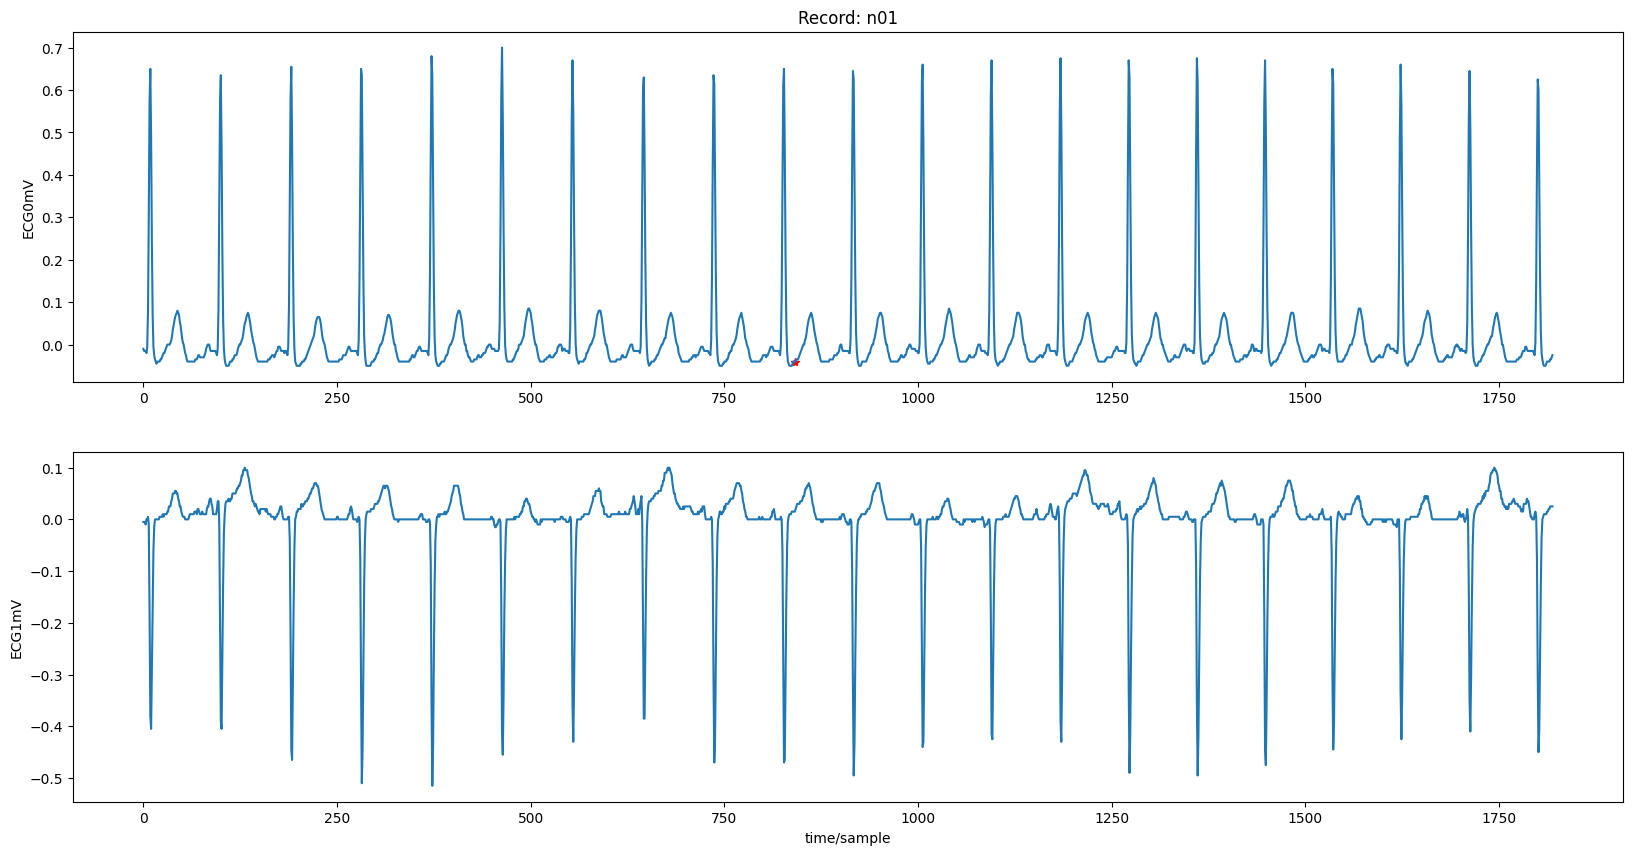

In [ ]:
import wfdb
#WFDB es un paquete de python. Sirve para leer, escribir y procesar bases de datos en forma de onda (waveform database)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import signal as sg

archivo = f'/content/n01'
registro = wfdb.rdrecord(archivo, sampfrom=180, sampto=2000, )    
anotacion = wfdb.rdann(archivo, 'dat', sampfrom=180, sampto=2000,shift_samps=True)
wfdb.plot_wfdb(record=registro, annotation=anotacion,figsize=(20,10))

# **Filtro pasa-bandas**
Elimina el ruido muscular, la interferencia de 60Hz de la linea, interferencia de onda T y obtener solo.

la banda de frecuencia donde se espera maximizar la energía del QRS y conseguir el complejo es 5-15 Hz

El filtro pasabandas diseñado por pan y tompkins se pudo diseñar para una banda de 5-12Hz que funciona bien y es cercano al objetivo y está formado por

## **Filtro pasa-bajos**

La ecuación de diferencia del filtro es

$y(nT) = 2y(nT - T) -y(nT-2T) + x(nT) -2x(nT-6T) + x(nT-12T)$

donde:


$y(nT)$ es la señal obtenida

$x(nT)$ es la señal de entrada, en este caso el electrocardiograma

$n$ es un numero arbitrario

$T$ es el periodo de muestreo el cual es 128 muestras/s

Donde la frecuecia de corte es alrededor de 11Hz y la ganancia es 36. El retraso del proceso es de 6 muestras

## **Filtro pasa-altos**

Este filtro consiste en substraer la salida de un filtro pasa bajos de primer orden.

su ecuación de diferencias es:

$y(nT) = 32x(nT-16T) - y(nT-T) - x(nT) + x(nT-32T)$

La frecuencia de corte es alrededor de 5Hz y la ganancia es 32. El retraso es de 16 muestras

In [ ]:
def filtro_pasa_bandas(entrada):

  salida = None
  signal = entrada.copy()

  #FILTRO PASA BAJOS
  #y(nT) = 2y(nT-T) - y(nT - 2T) + x(nT) - 2x(nT-6T) + x(nT - 12T)
  for i in range(len(entrada)):
      signal[i] = entrada[i]   

      if (i >=1): 
        signal[i] += 2*signal[i - 1]  
      if(i>=2):
        signal[i] -= signal[i - 2]   
      if(i >=6):
        signal[i] -= 2*entrada[i-6]  
      if(i>=12):
        signal[i] +=entrada[i-12] 

    
    
  #tomo el resultado y le copio la señal resultante
  salida = signal.copy()

  #FILTRO PASA ALTOS
  #y = 32x(nT-16T) - y(nT-T) - x(nT) + x(nT - 32T)
  for i in range(len(entrada)):
         
        salida[i] = -1*signal[i]
        if(i>=1):
         salida[i] -= salida[i-1]
        if(i>=16):
          salida[i] += 32*signal[i-16]
        if(i >= 32):
          salida[i] += signal[i-32]

  #se normaliza el valor REVISARRRR
  max_val = max(max(salida), -min(salida))
  salida = salida/max_val

  return salida


In [ ]:
def derivada(entrada):

    #inicializo el resultado, la entrada es la salida del anterior
    salida = entrada.copy()
    T = 1/anotacion.fs

    #aplico el filtro de manera recursiva
    for i in range(len(entrada)):

      salida[i] = 0

      if(i>=1):
        salida[i] -= 2*entrada[i - 1]

      if (i>=2):
        salida[i] -= entrada[i-2]
      
      
      #---->averigua esta linea que viene <<<<------
      if(i>= 2 and i <= len(entrada)-2):
        salida[i] += 2*entrada[i+1]

      if(i>= 2 and i <= len(entrada)-3):
        salida[i] += entrada[i+2]

      salida[i] = (salida[i])/(8*T)

    return salida


In [ ]:
def sqr(entrada):

  return np.square(entrada)

In [ ]:
def ventana_integradora(entrada):

    salida = entrada.copy()
    win_size = round(0.15*anotacion.fs)
    sum = 0

    for j in range(win_size):
      sum += entrada[j]/win_size
      salida[j] = sum

    for i in range(win_size, len(salida)):
      sum += entrada[i]/win_size
      sum -= entrada[i-win_size]/win_size
      salida[i] = sum
   
    return salida



In [ ]:
def pan_tompkins_qrs(signal):

  entrada = signal.iloc[:,1].to_numpy()

  #filtro pasa_bandas
  global bpass
  bpass = filtro_pasa_bandas(entrada.copy())
  #imprimo la gráfica del filtro pasabandas

  plt.figure(figsize = (20,4), dpi = 100)
  plt.xticks(np.arange(0, len(bpass)+1, 100))
  plt.plot(bpass[32:len(bpass)-2])
  plt.xlabel('Samples')
  plt.ylabel('MLIImV')
  plt.title("Bandpassed Signal")
  
  
  
  #derivativo
  global derivativo
  derivativo = derivada(bpass.copy())

  # Plotting derived signal
  plt.figure(figsize = (20,4), dpi = 100)
  plt.xticks(np.arange(0, len(derivativo)+1, 150))
  plt.plot(derivativo[32:len(derivativo)-2])
  plt.xlabel('Samples')
  plt.ylabel('MLIImV')      
  plt.title("Derivative Signal")

  

  global cuadratica
  cuadratica = sqr(derivativo.copy())
  # Plotting squared signal
  plt.figure(figsize = (20,4), dpi = 100)
  plt.xticks(np.arange(0, len(cuadratica)+1, 150))
  plt.plot(cuadratica[32:len(cuadratica)-2])
  plt.xlabel('Samples')
  plt.ylabel('MLIImV')
  plt.title("Squared Signal")

  
  global ventana_movil
  ventana_movil = ventana_integradora(cuadratica.copy())
  # Plotting moving window integrated signal
  plt.figure(figsize = (20,4), dpi = 100)
  plt.xticks(np.arange(0, len(ventana_movil)+1, 150))
  plt.plot(ventana_movil[100:len(ventana_movil)-2])
  plt.xlabel('Samples')
  plt.ylabel('MLIImV')
  plt.title("Moving Window Integrated Signal")


In [ ]:
from scipy import signal as sg

class ritmo_cardiaco():

  def __init__(self,signal,freq):

    # inicializan las variables
    #SPKI estimación de la señal pico corriendo (es un pico que el algoritmo ha estblecido anteriormente como QRS)
    #NPKI #estimación del pico de ruido (con QRS establecido)
    #SPKF #estimación de la señal pico corriendo (cuando el complejo se consigue usando el segundo umbral)
    #NPKF estimación del pico de ruido (usando el segundo umbral)
    #RR1 primer promedio RR
    #THRESHOLD_I1 primer umbral inicialmente aplicado a la forma de ondas integrada
    #THRESHOLD_F1 primer umbral aplicado a la forma de ondas filtrada
    #RR2 segundo promedio RR
    #THRESHOLD_I2 segundo umbral inicialmente aplicado a la forma de ondas integrada
    #THRESHOLD_F2 segundo umbral aplicado a la forma de ondas filtrada

    self.RR1, self.RR2, self.probable_peaks, self.r_locs, self.peaks, self.result = ([] for i in range(6))
    self.SPKI, self.NPKI, self.THRESHOLD_I1, self.THRESHOLD_I2, self.SPKF, self.NPKF, self.THRESHOLD_F1, self.THRESHOLD_F2 = (0 for i in range(8))
   
    #bandera de onda T
    self.T_wave = False
    self.m_win = ventana_movil 
    self.b_pass = bpass
    self.samp_freq = freq
    self.signal = signal
    self.win_150ms = round(0.15*self.samp_freq)

    self.RR_low_limit = 0
    self.RR_high_limit = 0
    self.RR_missed_limit = 0
    self.RR_average1= 0


#===============================================================================
  def pico_aprox(self):

    #FFT convolucion para filtrar la señal y suavizarla (entrada, ventana, tamño de salida)
    slopes = sg.fftconvolve(self.m_win, np.full((25,), 1) / 25, mode='same')

    # Finding approximate peak locations
    #no entiendo bien esta linea, despues de hallar el punto de origen y fin de la onda, se calcula el ancho y si es menor o igual a 64 ms (la mitad de numero de muestras)
    for i in range(round(0.5*self.samp_freq) + 1,len(slopes)-1):      
        #cambio de signo
        if (slopes[i] > slopes[i-1]) and (slopes[i+1] < slopes[i]):
            self.peaks.append(i) 
  
#===============================================================================

  def ajustar_intervalo_rr(self,ind):

    #entrada: indice actual en el arreglo de picos

    #hallando los 8 RR más recientes desde el indice actual hasta el 7 anteriores
    #¿por que se divide entre la frecuencia?
    self.RR1 = np.diff(self.peaks[max(0,ind-8): ind+1])/self.samp_freq
    

    #calculo de promedio de RR
    self.RR_average1 = np.mean(self.RR1)
    RR_average2 = self.RR_average1


    #Hallando los 8 RR mas recientes entre RR low limit y RR high limit
    if(ind >= 8):
      for i in range(0,8):
        if(self.RR_low_limit < self.RR1[i] < self.RR_high_limit):
           self.RR2.append(self.RR1[i])

           #movimiento de la ventana
           if(len(self.RR2) > 8):
            self.RR2.remove(self.RR2[0])
            RR_average2 = np.mean(self.RR2)

    '''
    ajustando RR low limit y RR high limit
    los limites RR son
    RR LOW LIMIT = 92% RR AVERAGE2
    RR HIGH LIMIT = 116% RR AVERAGE 2
    RR MISSED LIMIT = 166% RR AVERAGE 2
    '''  
    if(len(self.RR2)>7 or ind < 8):
      self.RR_low_limit = 0.92*RR_average2
      self.RR_high_limit = 1.16*RR_average2
      self.RR_missed_limit = 1.66*RR_average2


#============================================================================================================  

  def searchback(self, peak_val, RRn, sb_win):
    '''
    Searchback
    parametros:
    peak_Val  localización del pico a considerar
    RRn: intervalo más reciente
    sb_win: searchback window = RRn*frecuencia PREGUNTARRRR

    '''

    #chequear si el intervalo RR más reciente es mayor que RR_missed_limit
    if(RRn > self.RR_missed_limit):
      #aqui se inicia la ventana de retroceso
      win_rr = self.m_win[peak_val - sb_win +1 : peak_val + 1]

      #hallar las localizaciones de x dentro de la ventana teniendo valores y mayores al umbral I1
      coord = np.asarray(win_rr > self.THRESHOLD_I1).nonzero()[0]


      #hallar la localización x del maximo pico en la ventana de busqueda
      if(len(coord) > 0):
        for posicion in coord:
          if(win_rr[posicion] == max(win_rr[coord])):
            x_max = posicion
            break

      else:
        x_max = None

      #Si se ha conseguido un valor pico
      if (x_max is not None):   
            # Update the thresholds corresponding to moving window integration
            self.SPKI = 0.25 * self.m_win[x_max] + 0.75 * self.SPKI                         
            self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
            self.Threshold_I2 = 0.5 * self.Threshold_I1         

            # Initialize a window to searchback 
            win_rr = self.b_pass[x_max - self.win_150ms: min(len(self.b_pass) -1, x_max)]  

            # Find the x locations inside the window having y values greater than Threshold F1                   
            coord = np.asarray(win_rr > self.Threshold_F1).nonzero()[0]

            # Find the x location of the max peak value in the search window
            if (len(coord) > 0):
              for posicion in coord:
                  if (win_rr[posicion] == max(win_rr[coord])):
                      r_max = posicion
                      break
            else:
              r_max = None

            # If the max peak value is found
            if (r_max is not None):
              # Update the thresholds corresponding to bandpass filter
              if self.b_pass[r_max] > self.Threshold_F2:                                                        
                  self.SPKF = 0.25 * self.b_pass[r_max] + 0.75 * self.SPKF                            
                  self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
                  self.Threshold_F2 = 0.5 * self.Threshold_F1      

                  # Append the probable R peak location                      
                  self.r_locs.append(r_max)     


#============================================================================================================  

  def hallar_onda_t(self, peak_val, RRn, ind, prev_ind):
    '''
    parametros:
    peak_val: el valor maximo
    RRn: el intervalo RR más reciente
    ind: indice actual
    prev_ind: indice anterior 

    '''
    #cuando un RR está entre 200ms<x<360ms se realiza un juego donde se ha hallado correctamnte el QRS es una onda T


    #si la máxima pendiente ocurre durante esa onda es menos a la mitad del QRS anterior, es una onda T, de lo contrario es un QRS
  
    if(self.m_win[peak_val] >= self.THRESHOLD_I1):
      if(ind >0 and 0.20 <RRn< 0.36):
        #se halla las mendiente de la onda actual y la anterior
        curr_slope = max(np.diff(self.m_win[peak_val-round(self.win_150ms/2): peak_val + 1]))
        last_slope = max(np.diff(self.m_win[self.peaks[prev_ind] - round(self.win_150ms/2) : self.peaks[prev_ind] + 1]))


        #si la pendiente de la onda actual es menor que la mitad que la pendiente de la onda anterior
        if(curr_slope< 0.5*last_slope):
          #la onda te es hallada y se actualiza el umbral de ruido  
          self.T_wave = True
          self.NPKI = 0.125*self.m_win[peak_val] + 0.875*self.NPKI

          #si no se halla una una onda T actualiza los umbrales
      if(not self.T_wave):
          if (self.probable_peaks[ind] > self.THRESHOLD_F1):   
                self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI                                         
                self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 
              
                #agrega la localización del pico r probable
                self.r_locs.append(self.probable_peaks[ind])
          
          else:

                self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI
                self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF 
    
    #actualiza los umbrales de ruido
    elif(self.m_win[peak_val] < self.THRESHOLD_I1) or (self.THRESHOLD_I1 < self.m_win[peak_val] < self.THRESHOLD_I2):
      self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
      self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF



#============================================================================================================  

  def ajustar_umbrales(self, peak_val, ind):
    '''
    ajustar el ruido y la señal umbral durante la fase de aprendizaje
    '''
    if (self.m_win[peak_val] >= self.THRESHOLD_I1): 
        # Update signal threshold
        self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI

        if (self.probable_peaks[ind] > self.THRESHOLD_F1):                                            
            self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

            # Append the probable R peak location
            self.r_locs.append(self.probable_peaks[ind])  

        else:
            # Update noise threshold
            self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                                    
        
    # Update noise thresholds    
    elif (self.m_win[peak_val] < self.THRESHOLD_I2) or (self.THRESHOLD_I2 < self.m_win[peak_val] < self.THRESHOLD_I1):
        self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
        self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF

#============================================================================================================  

  def actualizar_umbrales(self):
    '''
    actualizar el umbral de ruido y señal para la proxima iteración
    
    '''
    self.THRESHOLD_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
    self.THRESHOLD_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
    self.THRESHOLD_I2 = 0.5 * self.THRESHOLD_I1 
    self.THRESHOLD_F2 = 0.5 * self.THRESHOLD_F1
    self.T_wave = False 



#============================================================================================================  

  def ecg_searchback(self):
    '''
    retroceso en el ECG para incrementar la eficiencia

    '''

    #filtra las localizaciones de los picos R
    self.r_locs = np.unique(np.array(self.r_locs).astype(int))

    #inicializa una ventana para searchback

    win_200ms = round(0.2*self.samp_freq)

    for r_val in self.r_locs:
      coord = np.arange(r_val - win_200ms, min(len(self.signal), r_val + win_200ms + 1), 1)

      # Find the x location of the max peak value
      if (len(coord) > 0):
        for pos in coord:
            if (self.signal[pos] == max(self.signal[coord])):
                x_max = pos
                break
      else:
          x_max = None

      # Append the peak location
      if (x_max is not None):   
         self.result.append(x_max)


#============================================================================================================  

  def hallar_picos_r(self):
    '''
    R Peak Detection
    '''

    # Find approximate peak locations
    self.pico_aprox()

    # Iterate over possible peak locations
    for ind in range(len(self.peaks)):

        # Initialize the search window for peak detection
        peak_val = self.peaks[ind]
        win_300ms = np.arange(max(0, self.peaks[ind] - self.win_150ms), min(self.peaks[ind] + self.win_150ms, len(self.b_pass)-1), 1)
        max_val = max(self.b_pass[win_300ms], default = 0)

        # Find the x location of the max peak value
        if (max_val != 0):        
          x_coord = np.asarray(self.b_pass == max_val).nonzero()
          self.probable_peaks.append(x_coord[0][0])
        
        if (ind < len(self.probable_peaks) and ind != 0):
            # Adjust RR interval and limits
            self.ajustar_intervalo_rr(ind)
            
            # Adjust thresholds in case of irregular beats
            if (self.RR_average1 < self.RR_low_limit or self.RR_average1 > self.RR_missed_limit): 
                self.THRESHOLD_I1 /= 2
                self.THRESHOLD_F1 /= 2

            RRn = self.RR1[-1]

            # Searchback
            self.searchback(peak_val,RRn,round(RRn*self.samp_freq))

            # T Wave Identification
            self.hallar_onda_t(peak_val,RRn,ind,ind-1)

        else:
          # Adjust threholds
          self.ajustar_umbrales(peak_val,ind)

        # Update threholds for next iteration
        self.actualizar_umbrales()

    # Searchback in ECG signal 
    self.ecg_searchback()

    return self.result

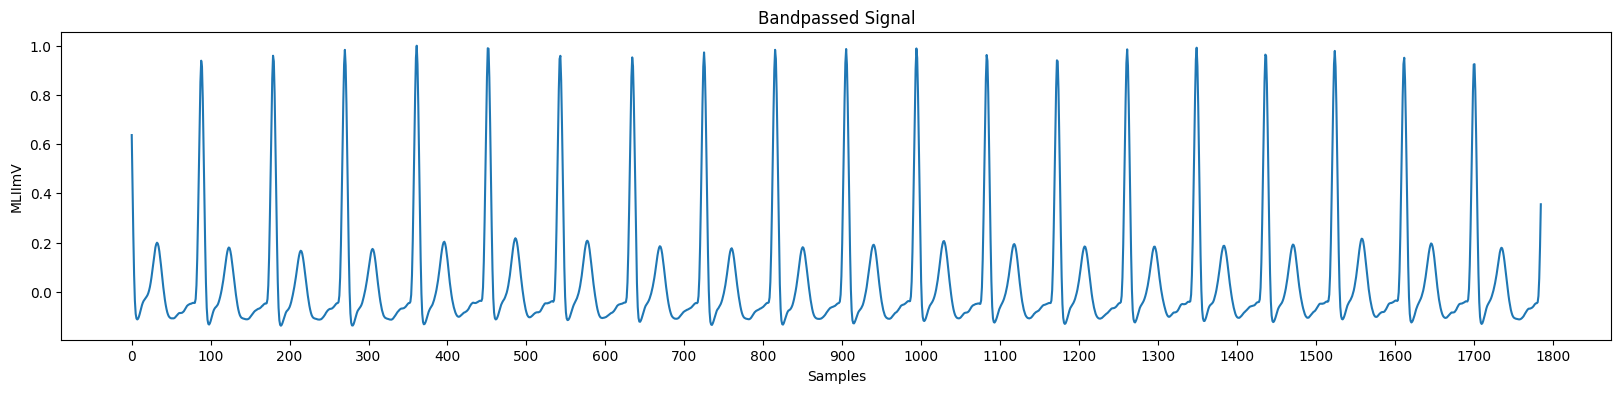

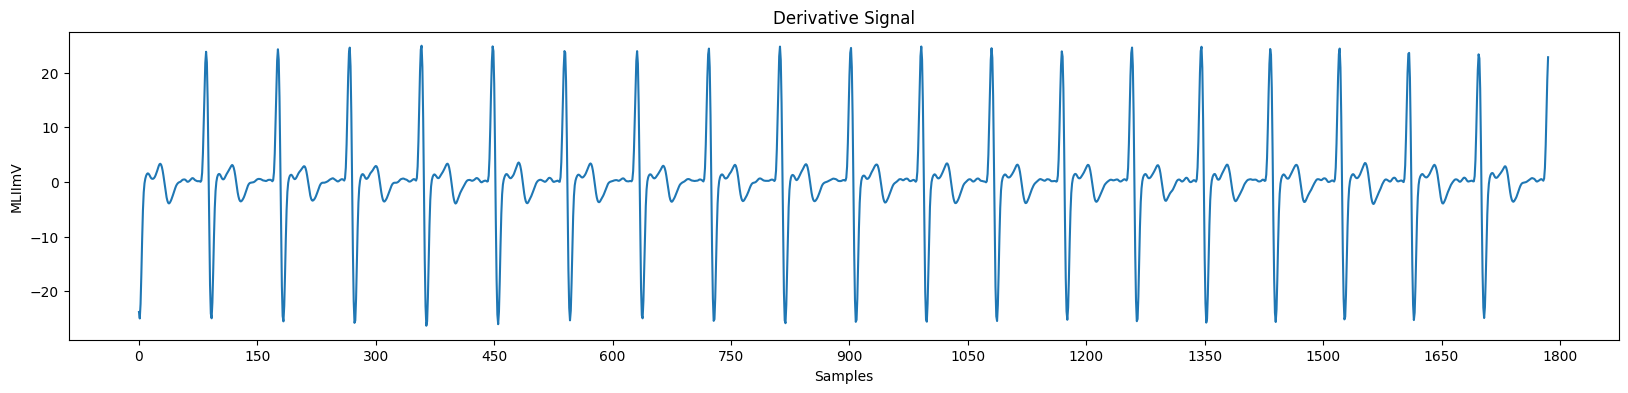

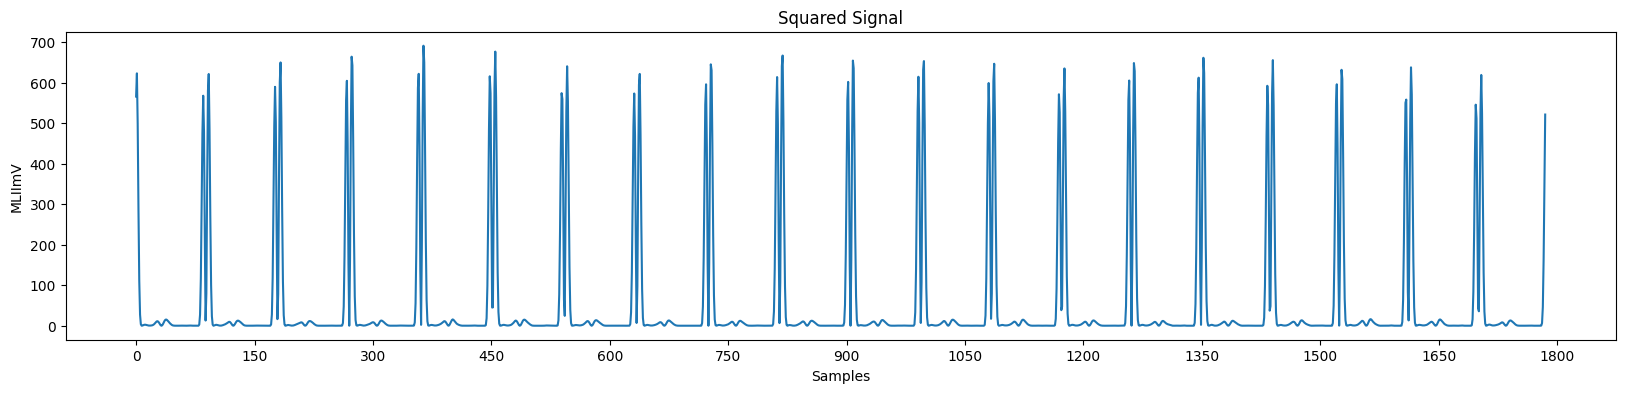

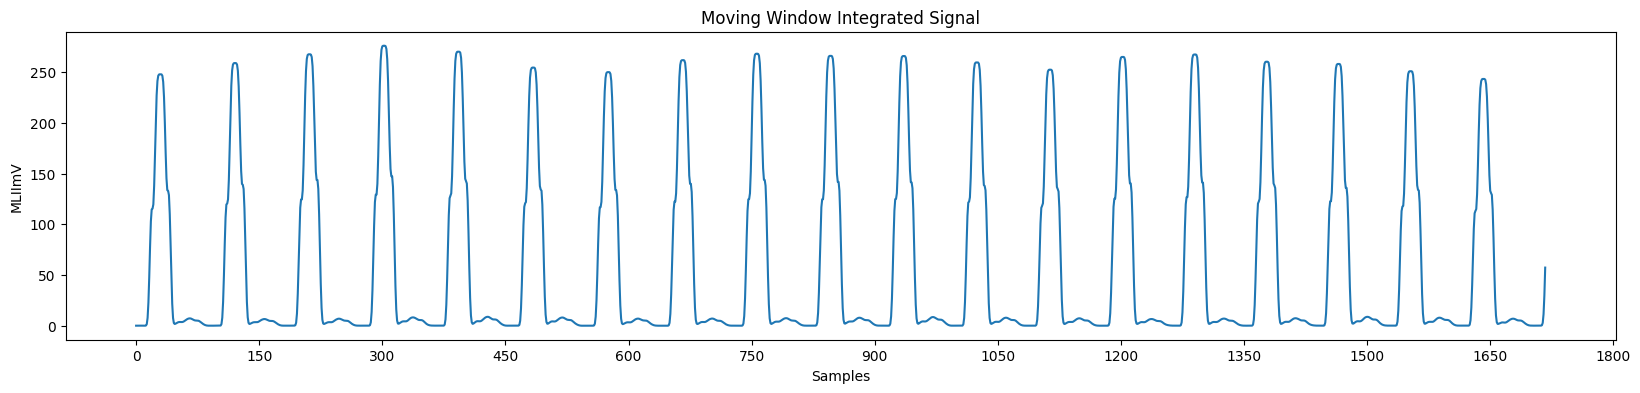

In [ ]:
#CODIGO PRINCIPAL
ecg = pd.DataFrame(np.array([list(range(len(registro.adc()))),registro.adc()[:,0]]).T,columns=['TimeStamp','ecg'])
ecg_integrada = pan_tompkins_qrs(ecg)
fs = anotacion.fs

Heart Rate 85.75682382133995 BPM


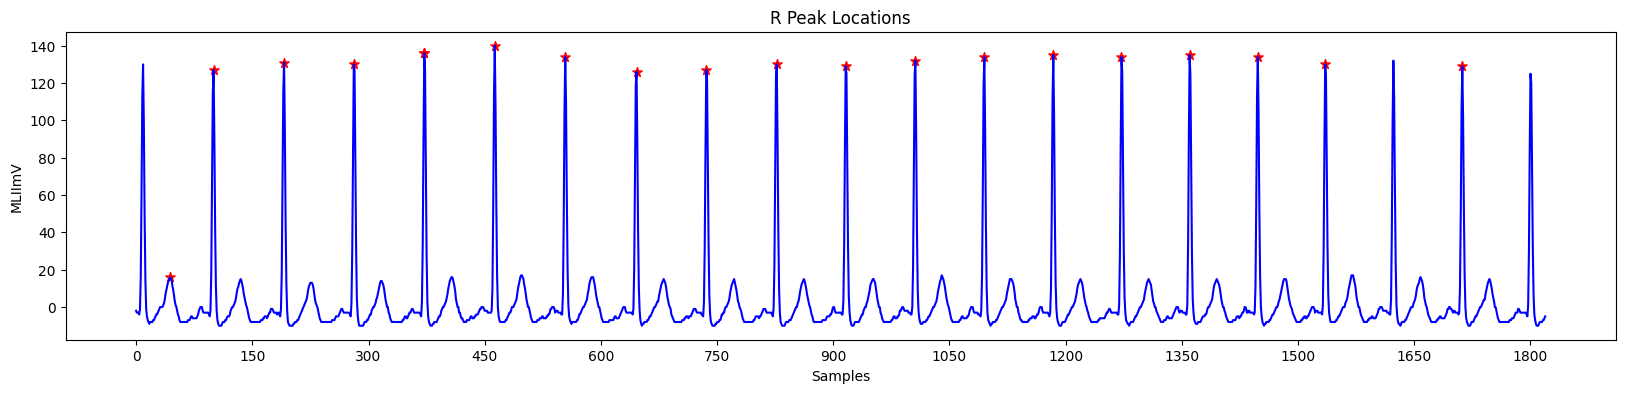

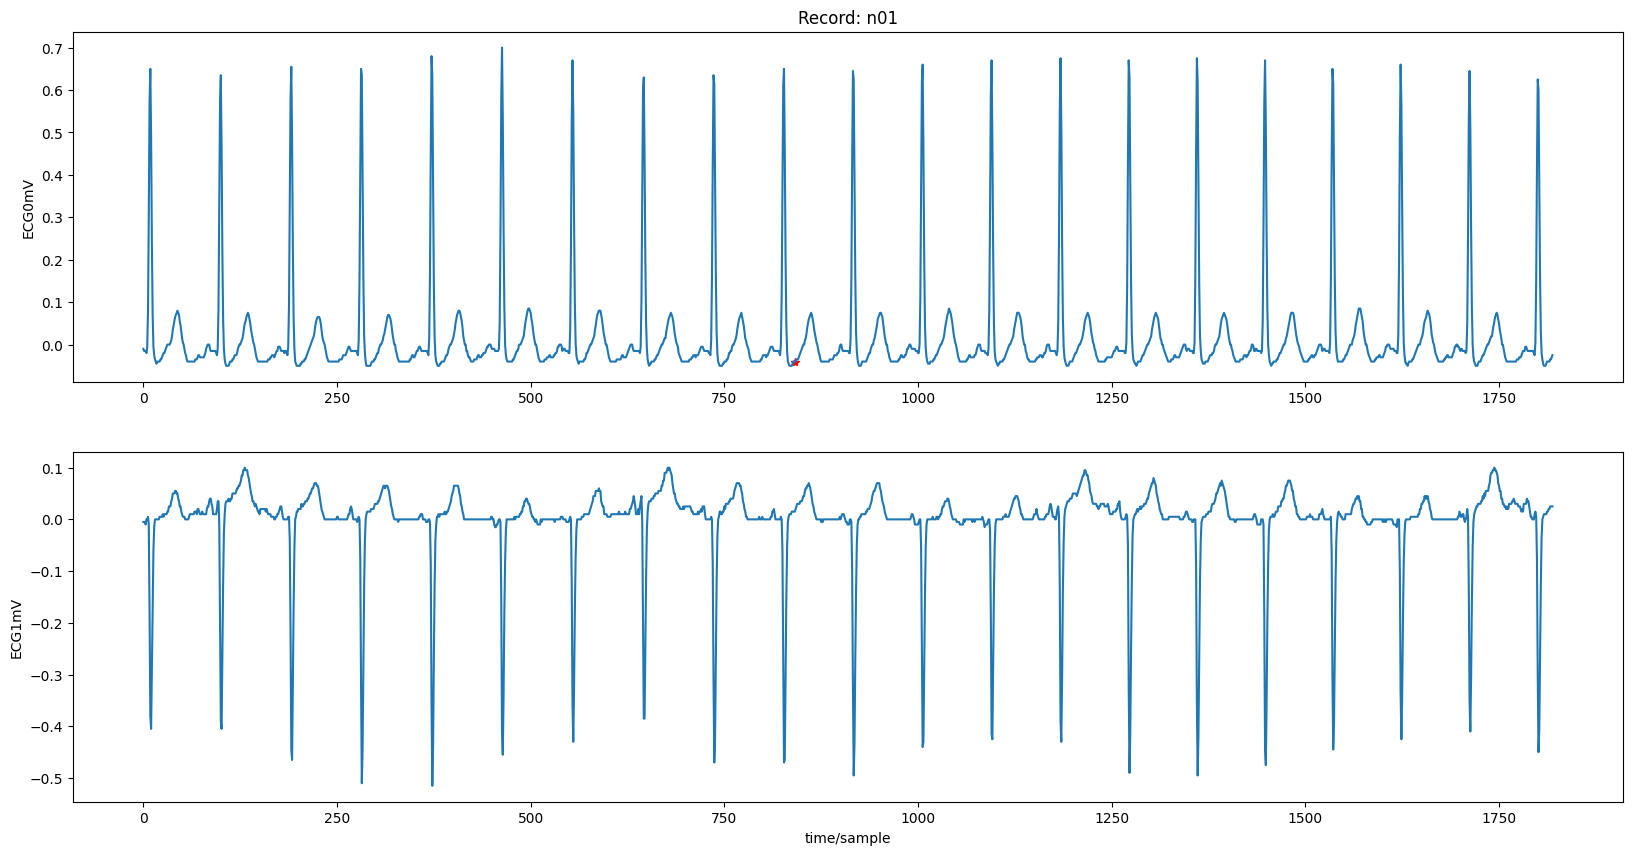

In [ ]:
#convierto ECG a un arreglo numpy
signal = ecg.iloc[:,1].to_numpy()

rc = ritmo_cardiaco(signal, fs)

result = rc.hallar_picos_r()
result = np.array(result)

# Clip the x locations less than 0 (Learning Phase)
result = result[result > 0]

# Calculate the heart rate
heartRate = (60*fs)/np.average(np.diff(result[1:]))
print("Heart Rate",heartRate, "BPM")

# Plotting the R peak locations in ECG signal
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(signal)+1, 150))
plt.plot(signal, color = 'blue')        
plt.scatter(result, signal[result], color = 'red', s = 50, marker= '*')
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("R Peak Locations")

wfdb.plot_wfdb(record=registro, annotation=anotacion,figsize=(20,10))

In [ ]:
print(result)

[  44  100  191  281  372  372  463  554  646  736  827  916 1006 1095
 1184 1272 1360 1448 1535 1712]
